In [2]:
import numpy as np
#from autograd import grad
import matplotlib.pyplot as plt
from scipy.optimize import minimize

#import tensorflow as tf
#import torch
np.set_printoptions(suppress=True)

import warnings
#suppress warnings
warnings.filterwarnings('ignore')

# Import data
X = np.load('../data/processed/data_tensor_JJ.npz')

N = X['N']
M = X['M']
y = X['y']
z = X['z']
n_y = X['n_y']
n_z = X['n_z']
area = X['area']
wind = X['wind']
distance = X['distance']
sI1 = X['sI1']
sI2 = X['sI2'] 
tI1 = X['tI1']
tI2 = X['tI2']
s_i = X['s_i']
s_j = X['s_j']

In [3]:
N

array([454, 454])

In [4]:
M

array([454, 454])

## Function

$$
\eta_{i}=\sum_{k=1}^{K} I_{k}^{(t)}(i)\left[\beta_{k}+\delta_{k}\left(\frac{\tilde{y}_{i}}{n_{\tilde{y}_{i}}} \exp{\left(-\eta_{1k} s_{i}\right)}\right)+\gamma_{k} \sum_{j=1}^{M_{i}}\left(\frac{a_{j} z_{j}}{n_{z_{j}}} \exp{\left(-\eta_{2k} s_{j}\right)} w_{i j} \exp{\left(-\alpha_{k} d_{i j}\right)} I_{k}^{(s)}(j)\right)\right]
$$

## Derivatives

$$
\begin{align*}
\frac{\partial \eta_{i}}{\partial \beta_{k}} &= I_{k}^{(t)}(i) \\

\frac{\partial \eta_{i}}{\partial \delta_{k}} &= I_{k}^{(t)}(i)\left(\frac{\tilde{y}_{i}}{n_{\tilde{y}_{i}}}\right) \exp \left(-\eta_{1 k} s_{i}\right) \\

\frac{\partial \eta_{i}}{\partial \eta_{1 k}} &= -I_{k}^{(t)}(i) \delta_{k} s_{i}\left(\frac{\tilde{y}_{i}}{n_{\tilde{y}_{i}}}\right) \exp \left(-\eta_{1 k} s_{i}\right) \\

\frac{\partial \eta_{i}}{\partial \eta_{2 k}} &= -\gamma_{k} I_{k}^{(t)}(i) \sum_{j=1}^{M_{i}}\left[\left(\frac{a_{j} z_{j}}{n_{z j}}\right) \exp \left(-\eta_{2 k} s_{j}\right) w_{i j} \exp \left(-\alpha_{k} d_{i j}\right) I_{k}^{(s)}(j) s_{j}\right] \\

\frac{\partial \eta_{i}}{\partial \gamma_{k}} &= I_{k}^{(t)}(i) \sum_{j=1}^{M_{i}}\left[\left(\frac{a_{j} z_{j}}{n_{z_{j}}}\right) \exp \left(-\eta_{2 k} s_{j}\right) w_{i j} \exp \left(-\alpha_{k} d_{i j}\right) I_{k}^{(s)}(j)\right] \\

\frac{\partial \eta_{i}}{\partial \alpha_{k}} &= -\gamma_{k} I_{k}^{(t)}(i) \sum_{j=1}^{M_{i}}\left[\left(\frac{a_{j} z_{j}}{n_{z_{j}}}\right) \exp \left(-\eta_{2 k} s_{j}\right) w_{i j} \exp \left(-\alpha_{k} d_{i j}\right) I_{k}^{(s)}(j) d_{i j}\right]
\end{align*}
$$

In [2]:
m = 1

N_i = int(N[m])

# Number of yards i in prior month
N_lag = int(N[m-1])

# Number of yards j in prior month
M_lag = int(M[m-1])

# Number of diseased plants in yard i in prior month
y_lag = y[m-1, 0:N_lag]
y_lag = y_lag.reshape(N_lag, 1)

# Number of plants sampled in yard i in prior month
n_y_lag = n_y[m-1, 0:N_lag]
n_y_lag = n_y_lag.reshape(N_lag, 1)

# Number of diseased plants in yard i in current month
y_i = y[m, 0:N[m]]
y_i = y_i.reshape(N[m], 1)

# Number of plants sampled in yard i in current month
n_y_i = n_y[m, 0:N[m]]
n_y_i = n_y_i.reshape(N[m], 1)

# Number of diseased plants in yard j in prior month
z_lag = y[m-1, 0:M_lag]
z_lag = z_lag.reshape(M_lag, 1)

# Number of plants sampled in yard j in prior month
n_z_lag = n_y[m-1, 0:M_lag]
n_z_lag = n_z_lag.reshape(M_lag, 1)

# Total monthly sprays for yard i in prior month
s_i_lag = s_i[m-1, 0:N_lag]
s_i_lag = s_i_lag.reshape(N_lag, 1)

# Total monthly sprays for yard j in prior month
s_j_lag = s_j[m-1, 0:M_lag]
s_j_lag = s_j_lag.reshape(M_lag, 1)

# Area in hectares of yard j [in prior month]
area_lag = area[m-1, 0:M_lag]
area_lag = area_lag.reshape(M_lag, 1)

# Wind run of yard j in prior month
wind_lag = wind[m-1, 0:N_lag, 0:M_lag]

# Distance in km between yard i and j [in prior month]
distance_lag = distance[m-1, 0:N_lag, 0:M_lag]

# Indicator on whether yard j is affected by an R6-virulent race in prior month
sI1_lag = sI1[m-1, 0:M_lag]
sI1_lag = sI1_lag.reshape(M_lag, 1)

# Constant array of 1's for yard j [in prior month]
sI2_lag = sI2[m-1, 0:M_lag]
sI2_lag = sI2_lag.reshape(M_lag, 1)

# Indicator on whether yard i is only susceptible to R6-virulent race in current month
tI1_i = tI1[m, 0:N[m]]
tI1_i = tI1_i.reshape(N[m], 1)

# Indicator on whether yard i is susceptible to both races in current month
tI2_i = tI2[m, 0:N[m]]
tI2_i = tI2_i.reshape(N[m], 1)

### Cost Function

$$J(\theta) = 
-\frac{1}{N} \sum_{i=1}^{N} y_{i} \eta_{i}-n_{i} \log \left(1+e^{\eta_{i}}\right)
$$

In [3]:
# Define the function eta() which takes input parameters theta and returns the log-odds of disease for each yard i in current time period
def eta(theta):
        
    beta1, beta2, delta1, delta2, gamma1, gamma2, alpha1, alpha2, eta11, eta12, eta21, eta22 = theta
    
    auto_infection1 = beta1 + delta1 * (y_lag / n_y_lag) * np.exp(-eta11 * s_i_lag)
    auto_infection2 = beta2 + delta2 * (y_lag / n_y_lag) * np.exp(-eta12 * s_i_lag)
    
    dispersal_component1 = gamma1 * np.sum(((area_lag * (z_lag / n_z_lag)) * np.exp(-eta21 * s_j_lag) * (wind_lag * np.exp(-alpha1 * distance_lag)).T * sI1_lag), axis=0, keepdims=True).T
    dispersal_component2 = gamma2 * np.sum(((area_lag * (z_lag / n_z_lag)) * np.exp(-eta22 * s_j_lag) * (wind_lag * np.exp(-alpha2 * distance_lag)).T * sI2_lag), axis=0, keepdims=True).T
    
    eta = tI1_i * (auto_infection1 + dispersal_component1) + tI2_i * (auto_infection2 + dispersal_component2)
    
    return eta


def costFunction(theta): 
    
    neg_log_likelihood = -(1/N_i) * np.sum(y_i * eta(theta) - n_y_i * np.log(1 + np.exp(eta(theta))))

    return neg_log_likelihood

# Numerical gradient of the cost function
#gradient = grad(costFunction)

In [ ]:
theta = np.random.normal(0, 1 / np.sqrt(N_i), size=(12, 1))

# Nelder-Mead algorithm
result = minimize(costFunction, theta, method='Nelder-Mead', options={'ftol': 1e-10, 'xtol': 1e-10, 'maxfev': 100000, 'disp': True})

theta = result['x']

theta = theta.reshape(12, 1)


# Powell's method
result = minimize(costFunction, theta, method='Powell', options={'ftol': 1e-10, 'xtol': 1e-10, 'maxfev': 1000000, 'disp': True})

# evaluate solution
theta = result['x']

theta = theta.reshape(12, 1)

# Nelder-Mead algorithm
result = minimize(costFunction, theta, method='Nelder-Mead', options={'ftol': 1e-8, 'xtol': 1e-8, 'maxfev': 100000, 'disp': True})

theta = result['x']

theta = theta.reshape(12, 1)

# Powell's method
result = minimize(costFunction, theta, method='Powell', options={'ftol': 1e-10, 'xtol': 1e-10, 'maxfev': 1000000, 'disp': True})

theta = result['x']

theta = theta.reshape(12, 1)


# Nelder-Mead algorithm
result = minimize(costFunction, theta, method='Nelder-Mead', options={'ftol': 1e-8, 'xtol': 1e-8, 'maxfev': 100000, 'disp': True})

# evaluate solution
theta = result['x']

theta = theta.reshape(12, 1)

print('cost: ', costFunction(theta))

In [5]:
theta = np.random.normal(0, 1 / np.sqrt(N_i), size=(12, 1))
#theta = np.load('../reports/theta2.npy')

# Broyden–Fletcher–Goldfarb–Shanno algorithm
result = minimize(costFunction, theta, method='BFGS', options={'gtol': 1e-15, 'maxiter': 10000, 'eps': 1e-10, 'disp': True})
# summarize the result
print('Status : %s' % result['message'])
print('Total Evaluations: %d' % result['nfev'])
# evaluate solution
theta = result['x']
evaluation = costFunction(theta)
print('Solution: J(%s) = %.5f' % (theta, evaluation))

theta = theta.reshape(12, 1)

         Current function value: 26.069936
         Iterations: 275
         Function evaluations: 4589
         Gradient evaluations: 353
Status : Desired error not necessarily achieved due to precision loss.
Total Evaluations: 4589
Solution: J([-2.35072067 -4.33370677  3.76571004  7.17964147 -0.00000021  6.23256426
 -0.56276041  1.31318226  0.08185145  0.40525544 -1.37320941  0.55941446]) = 26.06994


### Gradient

$$\frac{\partial J}{\partial \theta} =
-\frac{1}{N}\sum_{i=1}^{N} \frac{\partial \eta_{i}}{\partial \theta}\left(y_{i}-\frac{n_{i}}{1+e^{-\eta_{i}}}\right)
$$


### Hessian

$$\frac{\partial^2 J}{\partial \theta^2} = -\frac{1}{N}
\sum_{i=1}^{N}\left[\frac{\partial^{2} \eta_{i}}{\partial \theta^{2}}\left(y_{i}-\frac{n_{i}}{1+e^{-\eta_{i}}}\right)- n_{i} \left(\frac{\partial \eta_{i}}{\partial \theta}\right)^{2}\frac{e^{-\eta_{i}}}{\left(1+e^{-\eta_{i}}\right)^2}\right]
$$

## Optimization

In [4]:
def partial(theta):
    
    beta1, beta2, delta1, delta2, gamma1, gamma2, alpha1, alpha2, eta11, eta12, eta21, eta22 = theta
    
    d_beta1 = tI1_i
    d_beta2 = tI2_i
    
    d_delta1 = tI1_i * (y_lag / n_y_lag) * np.exp(-eta11 * s_i_lag)
    d_delta2 = tI2_i * (y_lag / n_y_lag) * np.exp(-eta12 * s_i_lag)
    
    d_gamma1 = tI1_i * np.sum(((area_lag * (z_lag / n_z_lag)) * np.exp(-eta21 * s_j_lag) * (wind_lag * np.exp(-alpha1 * distance_lag)).T * sI1_lag), axis=0, keepdims=True).T
    d_gamma2 = tI2_i * np.sum(((area_lag * (z_lag / n_z_lag)) * np.exp(-eta22 * s_j_lag) * (wind_lag * np.exp(-alpha2 * distance_lag)).T * sI2_lag), axis=0, keepdims=True).T
    
    d_alpha1 = -gamma1 * tI1_i * np.sum(((area_lag * (z_lag / n_z_lag)) * np.exp(-eta21 * s_j_lag) * (wind_lag * np.exp(-alpha1 * distance_lag)).T * sI1_lag * distance_lag.T), axis=0, keepdims=True).T
    d_alpha2 = -gamma2 * tI2_i * np.sum(((area_lag * (z_lag / n_z_lag)) * np.exp(-eta22 * s_j_lag) * (wind_lag * np.exp(-alpha2 * distance_lag)).T * sI2_lag * distance_lag.T), axis=0, keepdims=True).T
    
    d_eta11 = -tI1_i * delta1 * s_i_lag * (y_lag / n_y_lag) * np.exp(-eta11 * s_i_lag)
    d_eta12 = -tI2_i * delta2 * s_i_lag * (y_lag / n_y_lag) * np.exp(-eta12 * s_i_lag)

    d_eta21 = -gamma1 * tI1_i * np.sum(((area_lag * (z_lag / n_z_lag)) * np.exp(-eta21 * s_j_lag) * (wind_lag * np.exp(-alpha1 * distance_lag)).T * sI1_lag * s_j_lag), axis=0, keepdims=True).T
    d_eta22 = -gamma2 * tI2_i * np.sum(((area_lag * (z_lag / n_z_lag)) * np.exp(-eta22 * s_j_lag) * (wind_lag * np.exp(-alpha2 * distance_lag)).T * sI2_lag * s_j_lag), axis=0, keepdims=True).T

    grad_entries = np.array([d_beta1, d_beta2, d_delta1, d_delta2, d_gamma1, d_gamma2, d_alpha1, d_alpha2, d_eta11, d_eta12, d_eta21, d_eta22])
    
    return grad_entries

def partial_by_partial(theta):
    
    beta1, beta2, delta1, delta2, gamma1, gamma2, alpha1, alpha2, eta11, eta12, eta21, eta22 = theta
    
    d_beta1 = tI1_i
    d_beta2 = tI2_i
    
    d_delta1 = tI1_i * (y_lag / n_y_lag) * np.exp(-eta11 * s_i_lag)
    d_delta2 = tI2_i * (y_lag / n_y_lag) * np.exp(-eta12 * s_i_lag)
    
    d_gamma1 = tI1_i * np.sum(((area_lag * (z_lag / n_z_lag)) * np.exp(-eta21 * s_j_lag) * (wind_lag * np.exp(-alpha1 * distance_lag)).T * sI1_lag), axis=0, keepdims=True).T
    d_gamma2 = tI2_i * np.sum(((area_lag * (z_lag / n_z_lag)) * np.exp(-eta22 * s_j_lag) * (wind_lag * np.exp(-alpha2 * distance_lag)).T * sI2_lag), axis=0, keepdims=True).T
    
    d_alpha1 = -gamma1 * tI1_i * np.sum(((area_lag * (z_lag / n_z_lag)) * np.exp(-eta21 * s_j_lag) * (wind_lag * np.exp(-alpha1 * distance_lag)).T * sI1_lag * distance_lag.T), axis=0, keepdims=True).T
    d_alpha2 = -gamma2 * tI2_i * np.sum(((area_lag * (z_lag / n_z_lag)) * np.exp(-eta22 * s_j_lag) * (wind_lag * np.exp(-alpha2 * distance_lag)).T * sI2_lag * distance_lag.T), axis=0, keepdims=True).T
    
    d_eta11 = -tI1_i * delta1 * s_i_lag * (y_lag / n_y_lag) * np.exp(-eta11 * s_i_lag)
    d_eta12 = -tI2_i * delta2 * s_i_lag * (y_lag / n_y_lag) * np.exp(-eta12 * s_i_lag)

    d_eta21 = -gamma1 * tI1_i * np.sum(((area_lag * (z_lag / n_z_lag)) * np.exp(-eta21 * s_j_lag) * (wind_lag * np.exp(-alpha1 * distance_lag)).T * sI1_lag * s_j_lag), axis=0, keepdims=True).T
    d_eta22 = -gamma2 * tI2_i * np.sum(((area_lag * (z_lag / n_z_lag)) * np.exp(-eta22 * s_j_lag) * (wind_lag * np.exp(-alpha2 * distance_lag)).T * sI2_lag * s_j_lag), axis=0, keepdims=True).T

    grad_entries = np.array([[d_beta1*d_beta1, d_beta2*d_beta1, d_delta1*d_beta1, d_delta2*d_beta1, d_gamma1*d_beta1, d_gamma2*d_beta1, d_alpha1*d_beta1, d_alpha2*d_beta1, d_eta11*d_beta1, d_eta12*d_beta1, d_eta21*d_beta1, d_eta22*d_beta1],
                            [d_beta1*d_beta2, d_beta2*d_beta2, d_delta1*d_beta2, d_delta2*d_beta2, d_gamma1*d_beta2, d_gamma2*d_beta2, d_alpha1*d_beta2, d_alpha2*d_beta2, d_eta11*d_beta2, d_eta12*d_beta2, d_eta21*d_beta2, d_eta22*d_beta2],
                            [d_beta1*d_delta1, d_beta2*d_delta1, d_delta1*d_delta1, d_delta2*d_delta1, d_gamma1*d_delta1, d_gamma2*d_delta1, d_alpha1*d_delta1, d_alpha2*d_delta1, d_eta11*d_delta1, d_eta12*d_delta1, d_eta21*d_delta1, d_eta22*d_delta1],
                            [d_beta1*d_delta2, d_beta2*d_delta2, d_delta1*d_delta2, d_delta2*d_delta2, d_gamma1*d_delta2, d_gamma2*d_delta2, d_alpha1*d_delta2, d_alpha2*d_delta2, d_eta11*d_delta2, d_eta12*d_delta2, d_eta21*d_delta2, d_eta22*d_delta2],
                            [d_beta1*d_gamma1, d_beta2*d_gamma1, d_delta1*d_gamma1, d_delta2*d_gamma1, d_gamma1*d_gamma1, d_gamma2*d_gamma1, d_alpha1*d_gamma1, d_alpha2*d_gamma1, d_eta11*d_gamma1, d_eta12*d_gamma1, d_eta21*d_gamma1, d_eta22*d_gamma1],
                            [d_beta1*d_gamma2, d_beta2*d_gamma2, d_delta1*d_gamma2, d_delta2*d_gamma2, d_gamma1*d_gamma2, d_gamma2*d_gamma2, d_alpha1*d_gamma2, d_alpha2*d_gamma2, d_eta11*d_gamma2, d_eta12*d_gamma2, d_eta21*d_gamma2, d_eta22*d_gamma2],
                            [d_beta1*d_alpha1, d_beta2*d_alpha1, d_delta1*d_alpha1, d_delta2*d_alpha1, d_gamma1*d_alpha1, d_gamma2*d_alpha1, d_alpha1*d_alpha1, d_alpha2*d_alpha1, d_eta11*d_alpha1, d_eta12*d_alpha1, d_eta21*d_alpha1, d_eta22*d_alpha1],
                            [d_beta1*d_alpha2, d_beta2*d_alpha2, d_delta1*d_alpha2, d_delta2*d_alpha2, d_gamma1*d_alpha2, d_gamma2*d_alpha2, d_alpha1*d_alpha2, d_alpha2*d_alpha2, d_eta11*d_alpha2, d_eta12*d_alpha2, d_eta21*d_alpha2, d_eta22*d_alpha2],
                            [d_beta1*d_eta11, d_beta2*d_eta11, d_delta1*d_eta11, d_delta2*d_eta11, d_gamma1*d_eta11, d_gamma2*d_eta11, d_alpha1*d_eta11, d_alpha2*d_eta11, d_eta11*d_eta11, d_eta12*d_eta11, d_eta21*d_eta11, d_eta22*d_eta11],
                            [d_beta1*d_eta12, d_beta2*d_eta12, d_delta1*d_eta12, d_delta2*d_eta12, d_gamma1*d_eta12, d_gamma2*d_eta12, d_alpha1*d_eta12, d_alpha2*d_eta12, d_eta11*d_eta12, d_eta12*d_eta12, d_eta21*d_eta12, d_eta22*d_eta12],
                            [d_beta1*d_eta21, d_beta2*d_eta21, d_delta1*d_eta21, d_delta2*d_eta21, d_gamma1*d_eta21, d_gamma2*d_eta21, d_alpha1*d_eta21, d_alpha2*d_eta21, d_eta11*d_eta21, d_eta12*d_eta21, d_eta21*d_eta21, d_eta22*d_eta21],
                            [d_beta1*d_eta22, d_beta2*d_eta22, d_delta1*d_eta22, d_delta2*d_eta22, d_gamma1*d_eta22, d_gamma2*d_eta22, d_alpha1*d_eta22, d_alpha2*d_eta22, d_eta11*d_eta22, d_eta12*d_eta22, d_eta21*d_eta22, d_eta22*d_eta22]])
    
    
    
    return grad_entries

def partial_sq(theta):
    
    beta1, beta2, delta1, delta2, gamma1, gamma2, alpha1, alpha2, eta11, eta12, eta21, eta22 = theta
    
    # delta1 second derivatives
    
    d_delta1_d_eta11 = -tI1_i * (y_lag / n_y_lag) * np.exp(-eta11 * s_i_lag) * s_i_lag
    d_delta1_d_eta12 = 0
    
    d_delta2_d_eta11 = 0
    d_delta2_d_eta12 = -tI2_i * (y_lag / n_y_lag) * np.exp(-eta12 * s_i_lag) * s_i_lag
    
    d_gamma1_d_eta21 = -tI1_i * np.sum(((area_lag * (z_lag / n_z_lag)) * np.exp(-eta21 * s_j_lag) * (wind_lag * np.exp(-alpha1 * distance_lag)).T * sI1_lag * s_j_lag), axis=0, keepdims=True).T
    d_gamma1_d_eta22 = 0
    d_gamma1_d_alpha1 = -tI1_i * np.sum(((area_lag * (z_lag / n_z_lag)) * np.exp(-eta21 * s_j_lag) * (wind_lag * np.exp(-alpha1 * distance_lag)).T * sI1_lag * distance_lag.T), axis=0, keepdims=True).T
    d_gamma1_d_alpha2 = 0
    
    d_gamma2_d_eta21 = 0
    d_gamma2_d_eta22 = -tI2_i * np.sum(((area_lag * (z_lag / n_z_lag)) * np.exp(-eta22 * s_j_lag) * (wind_lag * np.exp(-alpha2 * distance_lag)).T * sI2_lag * s_j_lag), axis=0, keepdims=True).T
    d_gamma2_d_alpha1 = 0
    d_gamma2_d_alpha2 = -tI2_i * np.sum(((area_lag * (z_lag / n_z_lag)) * np.exp(-eta22 * s_j_lag) * (wind_lag * np.exp(-alpha2 * distance_lag)).T * sI2_lag * distance_lag.T), axis=0, keepdims=True).T
    
    d_alpha1_d_gamma1 = -tI1_i * np.sum(((area_lag * (z_lag / n_z_lag)) * np.exp(-eta21 * s_j_lag) * (wind_lag * np.exp(-alpha1 * distance_lag)).T * sI1_lag * distance_lag.T), axis=0, keepdims=True).T
    d_alpha1_d_gamma2 = 0
    d_alpha1_d_eta21 = gamma1 * tI1_i * np.sum(((area_lag * (z_lag / n_z_lag)) * np.exp(-eta21 * s_j_lag) * (wind_lag * np.exp(-alpha1 * distance_lag)).T * sI1_lag * distance_lag.T * s_j_lag), axis=0, keepdims=True).T
    d_alpha1_d_eta22 = 0
    d_alpha1_d_alpha1 = gamma1 * tI1_i * np.sum(((area_lag * (z_lag / n_z_lag)) * np.exp(-eta21 * s_j_lag) * (wind_lag * np.exp(-alpha1 * distance_lag)).T * sI1_lag * (distance_lag.T)**2), axis=0, keepdims=True).T
    d_alpha1_d_alpha2 = 0
    
    d_alpha2_d_gamma1 = 0
    d_alpha2_d_gamma2 = -tI2_i * np.sum(((area_lag * (z_lag / n_z_lag)) * np.exp(-eta22 * s_j_lag) * (wind_lag * np.exp(-alpha2 * distance_lag)).T * sI2_lag * distance_lag.T), axis=0, keepdims=True).T
    d_alpha2_d_eta21 = 0
    d_alpha2_d_eta22 = gamma2 * tI2_i * np.sum(((area_lag * (z_lag / n_z_lag)) * np.exp(-eta22 * s_j_lag) * (wind_lag * np.exp(-alpha2 * distance_lag)).T * sI2_lag * distance_lag.T * s_j_lag), axis=0, keepdims=True).T
    d_alpha2_d_alpha1 = 0
    d_alpha2_d_alpha2 = gamma2 * tI2_i * np.sum(((area_lag * (z_lag / n_z_lag)) * np.exp(-eta22 * s_j_lag) * (wind_lag * np.exp(-alpha2 * distance_lag)).T * sI2_lag * (distance_lag.T)**2), axis=0, keepdims=True).T
    
    d_eta11_d_delta1 = -tI1_i * s_i_lag * (y_lag / n_y_lag) * np.exp(-eta11 * s_i_lag)
    d_eta11_d_delta2 = 0
    d_eta11_d_eta11 = tI1_i * delta1 * (s_i_lag**2) * (y_lag / n_y_lag) * np.exp(-eta11 * s_i_lag)
    d_eta11_d_eta12 = 0
    
    d_eta12_d_delta1 = 0
    d_eta12_d_delta2 = -tI2_i * s_i_lag * (y_lag / n_y_lag) * np.exp(-eta12 * s_i_lag)
    d_eta12_d_eta11 = 0
    d_eta12_d_eta12 = tI2_i * delta2 * (s_i_lag**2) * (y_lag / n_y_lag) * np.exp(-eta12 * s_i_lag)
    
    d_eta21_d_gamma1 = -tI1_i * np.sum(((area_lag * (z_lag / n_z_lag)) * np.exp(-eta21 * s_j_lag) * (wind_lag * np.exp(-alpha1 * distance_lag)).T * sI1_lag * s_j_lag), axis=0, keepdims=True).T
    d_eta21_d_gamma2 = 0
    d_eta21_d_eta21 = gamma1 * tI1_i * np.sum(((area_lag * (z_lag / n_z_lag)) * np.exp(-eta21 * s_j_lag) * (wind_lag * np.exp(-alpha1 * distance_lag)).T * sI1_lag * (s_j_lag**2)), axis=0, keepdims=True).T
    d_eta21_d_eta22 = 0
    d_eta21_d_alpha1 = gamma1 * tI1_i * np.sum(((area_lag * (z_lag / n_z_lag)) * np.exp(-eta21 * s_j_lag) * (wind_lag * np.exp(-alpha1 * distance_lag)).T * sI1_lag * s_j_lag * (distance_lag.T)), axis=0, keepdims=True).T
    d_eta21_d_alpha2 = 0
    
    d_eta22_d_gamma1 = 0
    d_eta22_d_gamma2 = -tI2_i * np.sum(((area_lag * (z_lag / n_z_lag)) * np.exp(-eta22 * s_j_lag) * (wind_lag * np.exp(-alpha2 * distance_lag)).T * sI2_lag * s_j_lag), axis=0, keepdims=True).T
    d_eta22_d_eta21 = 0
    d_eta22_d_eta22 = gamma2 * tI2_i * np.sum(((area_lag * (z_lag / n_z_lag)) * np.exp(-eta22 * s_j_lag) * (wind_lag * np.exp(-alpha2 * distance_lag)).T * sI2_lag * (s_j_lag**2)), axis=0, keepdims=True).T
    d_eta22_d_alpha1 = 0
    d_eta22_d_alpha2 = gamma2 * tI2_i * np.sum(((area_lag * (z_lag / n_z_lag)) * np.exp(-eta22 * s_j_lag) * (wind_lag * np.exp(-alpha2 * distance_lag)).T * sI2_lag * s_j_lag * (distance_lag.T)), axis=0, keepdims=True).T
    
    zero = np.zeros((N_i, 1))
    
    hess_entries = np.array([[zero, zero, zero, zero, zero, zero, zero, zero, zero, zero, zero, zero],    #d_beta1
                             [zero, zero, zero, zero, zero, zero, zero, zero, zero, zero, zero, zero],    #d_beta2
                             [zero, zero, zero, zero, zero, zero, zero, zero, d_eta11_d_delta1, zero, zero, zero],    #d_delta1
                             [zero, zero, zero, zero, zero, zero, zero, zero, zero, d_eta12_d_delta2, zero, zero],    #d_delta2
                             [zero, zero, zero, zero, zero, zero, d_alpha1_d_gamma1, zero, zero, zero, d_eta21_d_gamma1, zero],    #d_gamma1
                             [zero, zero, zero, zero, zero, zero, zero, d_alpha2_d_gamma2, zero, zero, zero, d_eta22_d_gamma2],    #d_gamma2
                             [zero, zero, zero, zero, d_gamma1_d_alpha1, zero, d_alpha1_d_alpha1, zero, zero, zero, d_eta21_d_alpha1, zero],    #d_alpha1
                             [zero, zero, zero, zero, zero, d_gamma2_d_alpha2, zero, d_alpha2_d_alpha2, zero, zero, zero, d_eta22_d_alpha2],    #d_alpha2
                             [zero, zero, d_delta1_d_eta11, zero, zero, zero, zero, zero, d_eta11_d_eta11, zero, zero, zero],    #d_eta11
                             [zero, zero, zero, d_delta2_d_eta12, zero, zero, zero, zero, zero, d_eta12_d_eta12, zero, zero],    #d_eta12
                             [zero, zero, zero, zero, d_gamma1_d_eta21, zero, d_alpha1_d_eta21, zero, zero, zero, d_eta21_d_eta21, zero],    #d_eta21
                             [zero, zero, zero, zero, zero, d_gamma2_d_eta22, zero, d_alpha2_d_eta22, zero, zero, zero, d_eta22_d_eta22]])   #d_eta22
    
    
    return hess_entries



# Gradient
def gradient(theta):
    
    mu = y_i - (n_y_i / (1 + np.exp(-eta(theta))))
    
    # Gradient entries
    gradient = - (1 / N_i) * np.sum((partial(theta) * mu), axis=1)
    
    return gradient


# Hessian
def hessian(theta):
    
    mu = y_i - (n_y_i / (1 + np.exp(-eta(theta))))
    
    # Hessian entries
    hessian = - (1 / N_i) * np.sum((partial_sq(theta) * mu - n_y_i * (partial_by_partial(theta)) * (np.exp(-eta(theta)) / (1 + np.exp(-eta(theta)))**2)), axis=2)
    hessian = hessian.reshape((12, 12))
    
    return hessian


# Adam optimizer
def adam(theta, alpha, num_iters, b_1=0.9, b_2=0.999, eps=1e-8, tolerance=1e-5):

    # Make a copy of theta, to avoid changing the original array, since numpy arrays are passed by reference to functions
    theta = theta.copy()
    
    # Use a python list to save cost in every iteration
    J_history = []
    
    m = np.zeros(theta.shape)
    v = np.zeros(theta.shape)
    
    for i in range(num_iters):
        
        # Gradient
        g = gradient(theta)

        # First moment
        m = b_1 * m + (1 - b_1) * g

        # Second moment
        v = b_2 * v + (1 - b_2) * g**2

        # Bias correction for the first and second moments

        mhat = m / (1 - b_1**(i+1))

        vhat = v / (1 - b_2**(i+1))
        
        change = alpha * mhat / (np.sqrt(vhat) + eps)
        
        # Update parameter theta
        theta = theta - change
        
        # save the cost J in every iteration
        J_history.append(costFunction(theta))
        # report progress
        print('#', i , 'cost: ', costFunction(theta), 'MaxGrad: ', np.max(np.abs(gradient(theta))), 'MinEig: ', np.min(np.linalg.eigvalsh(hessian(theta))))
        
        if np.max(np.abs(gradient(theta))) <= tolerance:
            break
        
    return theta, J_history


# Gradient descent algorithm
def gradientDescent(theta, alpha, num_iters):

    # Make a copy of theta, to avoid changing the original array, since numpy arrays are passed by reference to functions
    theta = theta.copy()
    
    # Use a python list to save cost in every iteration
    J_history = []
    
    # Update parameter theta using the gradient
    for i in range(num_iters):
        
        theta = theta - alpha * gradient(theta)
        
        # save the cost J in every iteration
        J_history.append(costFunction(theta))
        # report progress
        #print('iteration: ', i, 'cost: ', costFunction(theta), 'normGradient: ', np.linalg.norm(gradient(theta)))
    return theta, J_history


# AdaGrad algorithm
def adagrad(theta, alpha, num_iters, eps=1e-8):

    # Make a copy of theta, to avoid changing the original array, since numpy arrays are passed by reference to functions
    theta = theta.copy()
    
    # Use a python list to save cost in every iteration
    J_history = []
    
    # Update parameter theta using the gradient
    for i in range(num_iters):
        g = gradient(theta)
        
        theta = theta - (alpha / (eps + np.sqrt(g**2))) * g
        
        # save the cost J in every iteration
        J_history.append(costFunction(theta))
        # report progress
        #print('iteration: ', i, 'cost: ', costFunction(theta))
    return theta, J_history

# 0 cost:  113.24342285256097 MaxGrad:  311.2650748572668 MinEig:  -3290.888132475586
# 1 cost:  109.53304194064981 MaxGrad:  267.9463797619454 MinEig:  -2940.6740232558627
# 2 cost:  106.5030098088733 MaxGrad:  239.04012563406434 MinEig:  -2729.140020645138
# 3 cost:  103.80074804779066 MaxGrad:  222.69006280001096 MinEig:  -2652.775607161952
# 4 cost:  101.1399177280024 MaxGrad:  216.1802654840648 MinEig:  -2691.321440317623
# 5 cost:  98.32453328892487 MaxGrad:  216.54137534532268 MinEig:  -2810.395772125887
# 6 cost:  95.22950396984105 MaxGrad:  221.2245948164226 MinEig:  -2966.9197986819568
# 7 cost:  91.77217596029867 MaxGrad:  228.16487645963443 MinEig:  -3106.855528716887
# 8 cost:  87.89800353550046 MaxGrad:  235.51638188516299 MinEig:  -3157.8434938675623
# 9 cost:  83.58115034249641 MaxGrad:  241.3748122877187 MinEig:  -3023.879636135923
# 10 cost:  78.83598259735238 MaxGrad:  245.76268505959092 MinEig:  -2592.836843482998
# 11 cost:  73.73548341056728 MaxGrad:  271.27478553

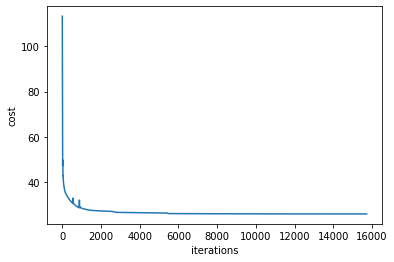

In [40]:
# initialize fitting parameters

# Xavier initialization for theta
theta = np.random.normal(0, 1 / np.sqrt(N_i), size=(12, 1))

# Use below theta to continue from checkpoint
#checkpoint = np.load('../reports/checkpoint_BFGS_adam.npy', allow_pickle=True)
#theta = checkpoint[0]

#theta = np.load('../reports/theta2.npy')

# Gradient descent settings
iterations = 1000000

alpha = 0.009 # learning rate

theta, J_history = adam(theta, alpha, iterations)

#print('iteration start:\t{:.3f}'.format(np.int32(checkpoint[1])))
#print('previous final cost:\t{:.3f}'.format(checkpoint[2]))
print('updated final cost:\t{:.3f}'.format(J_history[-1]))
#print('theta: \n', theta)

plt.plot(list(range(1, len(J_history) + 1)), J_history)
plt.xlabel('iterations')
plt.ylabel('cost')
plt.show()

# Save trained parameters

#iterations += checkpoint[1]
checkpoint = np.array([theta, iterations, J_history], dtype=object)
np.save('../reports/checkpoint_June_July2.npy', checkpoint)

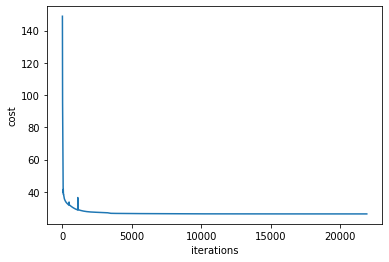

In [21]:
plt.plot(list(range(1, len(J_history) + 1)), J_history)
plt.xlabel('iterations')
plt.ylabel('cost')
plt.show()

In [50]:
#checkpoint = np.array([theta, iterations, J_history], dtype=object)
#np.save('../reports/checkpoint_June_July2_backup.npy', checkpoint)

In [45]:
checkpoint = np.load('../reports/checkpoint_June_July2.npy', allow_pickle=True)
theta = checkpoint[0]

In [46]:
theta

array([[-2.89902093],
       [-4.33376942],
       [ 3.86406603],
       [ 7.1830044 ],
       [ 0.06209235],
       [ 6.21221296],
       [ 0.17578305],
       [ 1.31264131],
       [ 0.13978209],
       [ 0.40521989],
       [-0.79182359],
       [ 0.55742334]])

## Parameter Estimation

## Function

$$
\eta_{i}=\sum_{k=1}^{K} I_{k}^{(t)}(i)\left[\beta_{k}+\delta_{k}\left(\frac{\tilde{y}_{i}}{n_{\tilde{y}_{i}}} \exp{\left(-\eta_{1k} s_{i}\right)}\right)+\gamma_{k} \sum_{j=1}^{M_{i}}\left(\frac{a_{j} z_{j}}{n_{z_{j}}} \exp{\left(-\eta_{2k} s_{j}\right)} w_{i j} \exp{\left(-\alpha_{k} d_{i j}\right)} I_{k}^{(s)}(j)\right)\right]
$$

$$\beta_1 = -2.89902093$$
$$\beta_2 = -4.33376942$$
$$\delta_1 = 3.86406603$$
$$\delta_2 = 7.1830044$$
$$\gamma_1 = 0.06209235$$
$$\gamma_2 = 6.21221296$$
$$\alpha_1 = 0.17578305$$
$$\alpha_2 = 1.31264131$$
$$\eta_{11} = 0.13978209$$
$$\eta_{12} = 0.40521989$$
$$\eta_{21} = -0.79182359$$
$$\eta_{22} = 0.55742334$$

## Eigenvalues of Hessian

In [47]:
np.linalg.eigvalsh(hessian(theta))

array([  0.00485402,   0.00964528,   0.07472232,   0.12873243,
         0.23575416,   0.84603842,   1.21874942,   4.92745909,
         6.35725232,  16.483655  ,  22.27732358, 636.0293171 ])

## Gradient

In [49]:
gradient(theta)

array([[ 0.00000023],
       [ 0.00000001],
       [-0.00000005],
       [ 0.00000004],
       [ 0.00000964],
       [-0.00000775],
       [ 0.00000072],
       [-0.00000052],
       [ 0.00000007],
       [-0.00000005],
       [ 0.00000951],
       [-0.00000021]])

In [31]:
nGrad = nd.Gradient(costFunction)
nHess = nd.Hessian(costFunction)
hess_theta = nHess(theta.reshape(12,))
grad_theta = nGrad(theta.reshape(12,))

In [20]:
theta

array([[-2.32963578],
       [-4.3386466 ],
       [ 3.75790402],
       [ 7.4317041 ],
       [-0.00002778],
       [ 4.96724831],
       [-0.48046568],
       [ 1.23292237],
       [ 0.08117348],
       [ 0.40587453],
       [-0.42012453],
       [ 0.44573774]])

In [17]:
costFunction(theta)

16.594517860974094

In [24]:
def prob(theta):
    
    p = 1 / (1 + np.exp(-eta(theta)))
    
    return p

In [26]:
print('estimated probability of disease: \n', prob(theta))

estimated probability of disease: 
 [[0.01391396]
 [0.0141944 ]
 [0.01464914]
 [0.01620743]
 [0.08546231]
 [0.0199657 ]
 [0.01336707]
 [0.01336694]
 [0.01367728]
 [0.01387217]
 [0.01505788]
 [0.0156512 ]
 [0.01423901]
 [0.01405462]
 [0.01677085]
 [0.01410411]
 [0.01325574]
 [0.01327012]
 [0.01297749]
 [0.0138138 ]
 [0.01328902]
 [0.01395437]
 [0.01863181]
 [0.01572601]
 [0.0139124 ]
 [0.01393081]
 [0.01298208]
 [0.01321246]
 [0.01332875]
 [0.01340481]
 [0.01344471]
 [0.01344256]
 [0.0134923 ]
 [0.01354833]
 [0.41439119]
 [0.09884865]
 [0.02815236]
 [0.03785603]
 [0.02306572]
 [0.02427979]
 [0.05109043]
 [0.03589815]
 [0.03245456]
 [0.02791927]
 [0.09381392]
 [0.12966226]
 [0.08971652]
 [0.0800253 ]
 [0.92468842]
 [0.62435387]
 [0.9688238 ]
 [0.48053558]
 [0.55407132]
 [0.61882603]
 [0.01326805]
 [0.01445529]
 [0.01314503]
 [0.07640226]
 [0.01476081]
 [0.07816936]
 [0.08347754]
 [0.08550667]
 [0.09692384]
 [0.01570457]
 [0.01478177]
 [0.07840872]
 [0.01318024]
 [0.01355903]
 [0.0137946 